# Detecting Car plates
* Load images
* load labels VOC format
* scaleup 
* train 
* test

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import os
import glob
from lxml import etree
import random
from skimage import io


from datetime import datetime

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model

from keras.applications.imagenet_utils import preprocess_input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from zipfile import ZipFile

with ZipFile('drive/MyDrive/Cars_license_plate_data/Cars.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('drive/MyDrive/Cars_license_plate_data/Unzip_cars_files')


# Constants

In [3]:
IMAGE_SIZE = 224
# old case
img_dir = "drive/MyDrive/Cars_license_plate_data/Unzip_cars_files/"
xml_dir = img_dir
# new case
img_dir = "drive/MyDrive/Cars_license_plate_data/Unzip_cars_files/data/Label_image_800/"
xml_dir = "drive/MyDrive/Cars_license_plate_data/Unzip_cars_files/data/Label_xml_800/"
data_path = os.path.join(img_dir,'*jpg')
labels_path=os.path.join(xml_dir,'*xml')


# Load and Prepare data

In [4]:
def resize_one_label(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]


files = glob.glob(data_path)
files.sort()
#files=random.sample(files, 100)
X=[]
y=[]
for f in tqdm(files):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # Preprocess images
    
    #img_transf = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #img_transf[:,:,2] = cv2.equalizeHist(img_transf[:,:,2])
    #img = cv2.cvtColor(img_transf, cv2.COLOR_HSV2RGB)
    #########################
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    img = preprocess_input(img)
    X.append(np.array(img))
    # load labels
    fxml=xml_dir+(os.path.basename(f).split("jpg"))[0]+"xml"
    y.append(resize_one_label(fxml))

100%|██████████| 5209/5209 [01:58<00:00, 43.94it/s]


In [5]:
X=np.array(X)
y=np.array(y)

In [6]:
X.shape,y.shape

((5209, 224, 224, 3), (5209, 4))

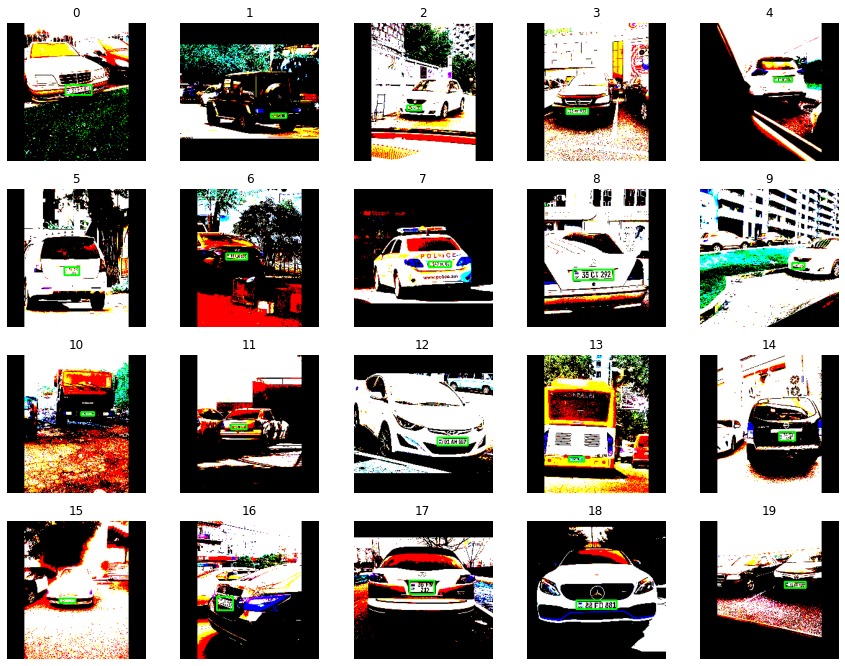

In [43]:
plt.figure(figsize=(15,30))
for i_car in range(0,20) :
    plt.subplot(10,5,i_car+1)
    plt.axis('off')
    image=X[i_car].copy()
    image = cv2.rectangle(image,(y[i_car][0],y[i_car][1]),(y[i_car][2],y[i_car][3]),(0, 255, 0),2)
    plt.title(f"{i_car}")
    plt.imshow(image)

# Normalize!!!
* coordinates [0,1]
* colorspace  [0,1]

In [7]:
X = X / 255
y = y / 255

In [8]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion) #should be int
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    y_train = target[ratio:,:]
    y_test =  target[:ratio,:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = shuffle(X, y, 3)

In [10]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = shuffle(X_train, y_train, 3)

# Build the CNN based on transfer learning technique

In [11]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


num_classes=4


model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(num_classes, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 17,951,108
Trainable params: 3,236,420
Non

# Train model 

In [12]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=50, batch_size=5,
                  verbose=1,
                  callbacks=[tensorboard_callback],)

Epoch 1/50
464/464 [==============================] - 44s 69ms/step - loss: 0.0086 - accuracy: 0.6675 - val_loss: 0.0054 - val_accuracy: 0.8315
Epoch 2/50
464/464 [==============================] - 30s 66ms/step - loss: 0.0042 - accuracy: 0.7876 - val_loss: 0.0041 - val_accuracy: 0.7969
Epoch 3/50
464/464 [==============================] - 29s 63ms/step - loss: 0.0030 - accuracy: 0.8519 - val_loss: 0.0044 - val_accuracy: 0.8280
Epoch 4/50
464/464 [==============================] - 29s 62ms/step - loss: 0.0022 - accuracy: 0.8774 - val_loss: 0.0039 - val_accuracy: 0.8185
Epoch 5/50
464/464 [==============================] - 31s 66ms/step - loss: 0.0020 - accuracy: 0.8877 - val_loss: 0.0036 - val_accuracy: 0.8410
Epoch 6/50
464/464 [==============================] - 29s 62ms/step - loss: 0.0015 - accuracy: 0.9007 - val_loss: 0.0048 - val_accuracy: 0.7494
Epoch 7/50
464/464 [==============================] - 29s 63ms/step - loss: 0.0014 - accuracy: 0.9016 - val_loss: 0.0035 - val_accuracy:

# Test

In [13]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 87.33%


In [14]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

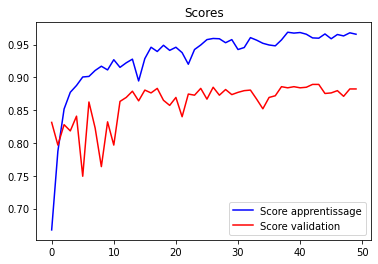

In [15]:
plot_scores(train)

In [0]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(20))
print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

20/20 [==============================] - 5s 136ms/step - loss: 0.0036 - accuracy: 0.8540
Test results 
 Loss: 0.0036105248145759106 
 Accuracy 0.8539999723434448


# Detection

In [16]:
y_cnn = model.predict(X_test)

(1, 224, 224, 3)
[0.44835484 0.9996997  0.02294805 0.9972452 ]
113


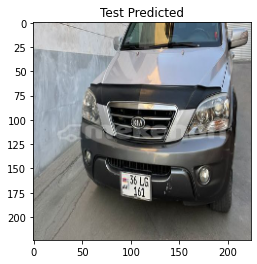

In [131]:
path1 = 'https://mekenan.s3.amazonaws.com/uploads/picture/url/48815/medium_with_watermark_kia-sorento-yerevan-yerevan-4059.jpeg'
test_img = io.imread(path1)
test_img = cv2.resize(test_img, (IMAGE_SIZE,IMAGE_SIZE))
test_img = tf.expand_dims(test_img, axis=0)
print(test_img.shape)
test_pred = model.predict(test_img)
print(test_pred[0])

ny1 = test_pred[0]*254
test_img = tf.squeeze(test_img).numpy()
test_img=(test_img).astype(np.uint8)
print(int(ny1[0]))
image=test_img
# image.shape
image = cv2.rectangle(image,(int(ny1[0]),int(ny1[1])),(int(ny1[2]),int(ny1[3])),(0, 255, 0))
plt.title('Test Predicted')
plt.imshow(image)

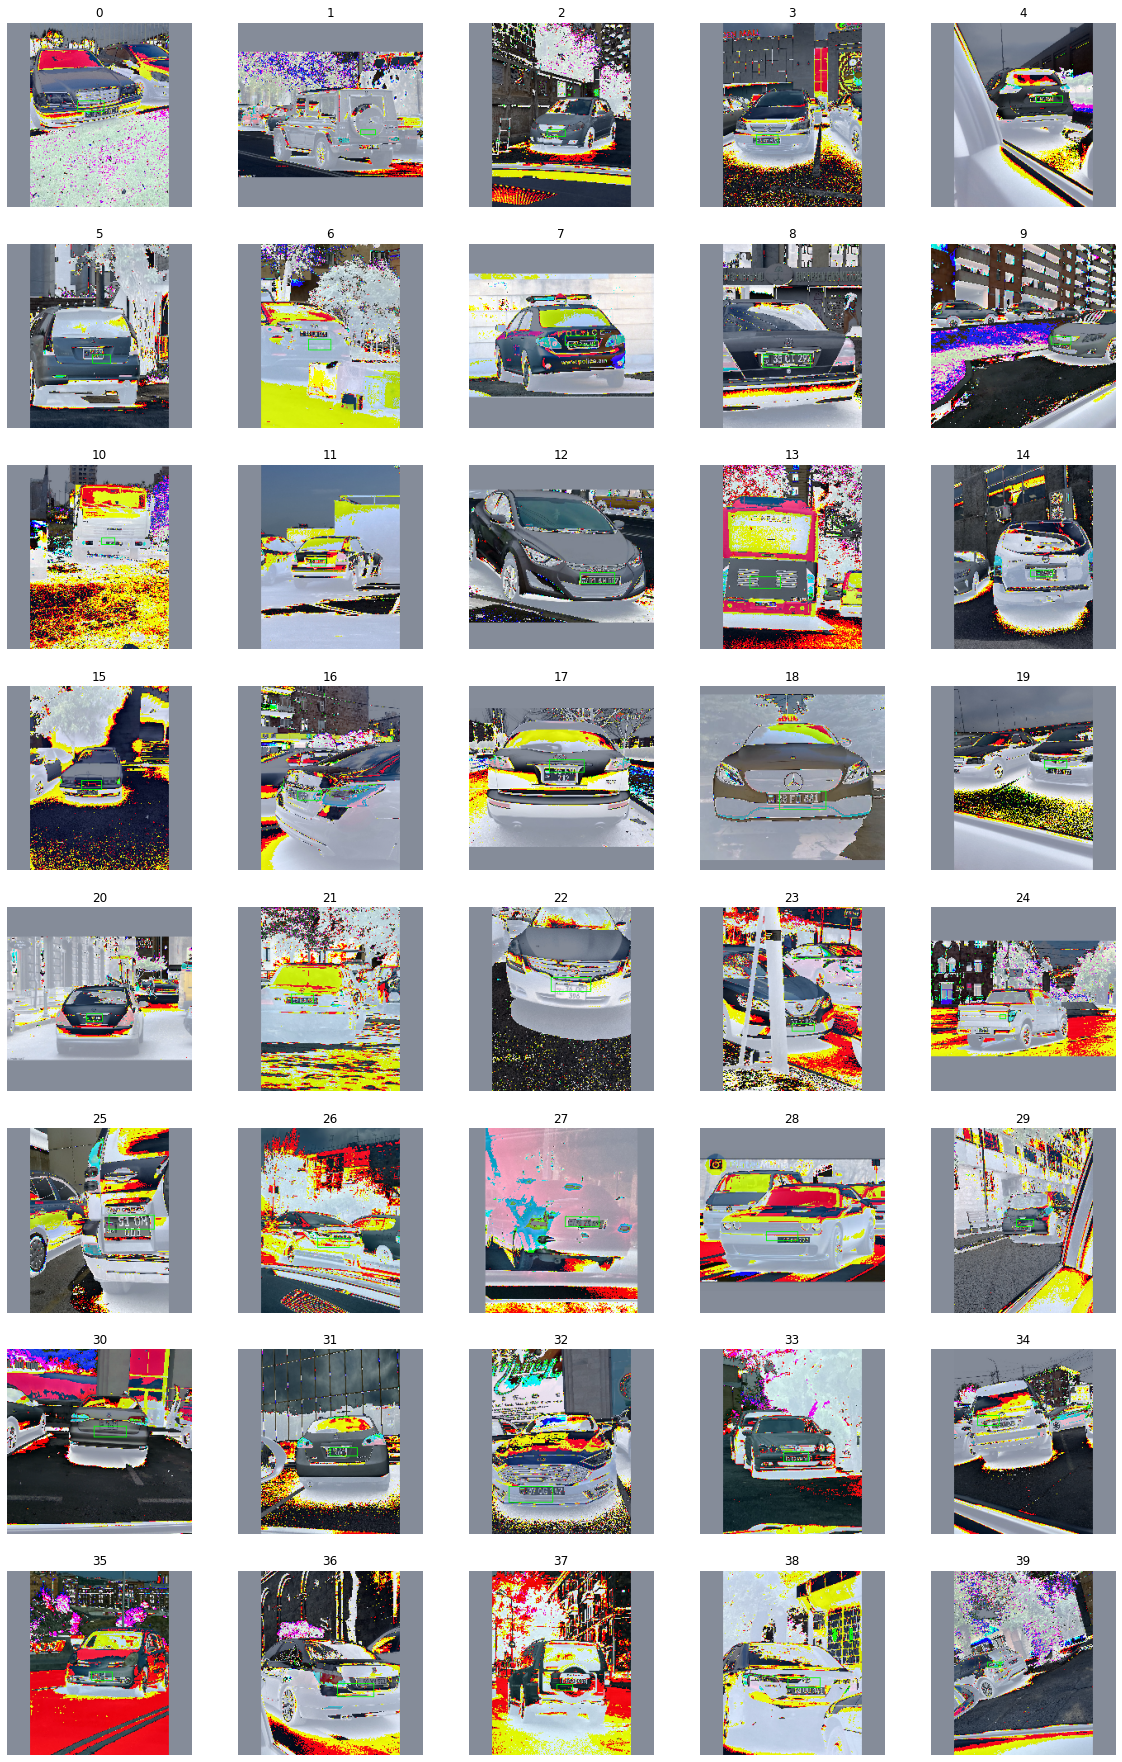

In [134]:
plt.figure(figsize=(20,40))
for i in range(0,40) :
    # i = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image=(X_test[i].copy()*255).astype(np.uint8)
    image = cv2.rectangle(image,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    image =  cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.title(f"{i}")
    plt.imshow(image)

# Test on seen data

## Load unknown data


In [141]:
img_dir = "drive/MyDrive/Cars_license_plate_data/Avt/"
xml_dir = img_dir
data_path = os.path.join(img_dir,'*jpg')
files = glob.glob(data_path)
print(len(files))
files.sort()

X_unkown=[]
for f in tqdm(files):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X_unkown.append(np.array(img))

X_unkown=np.array(X_unkown)
X_unkown = X_unkown / 255
y_cnn = model.predict(X_unkown)

5


100%|██████████| 5/5 [00:00<00:00, 110.31it/s]


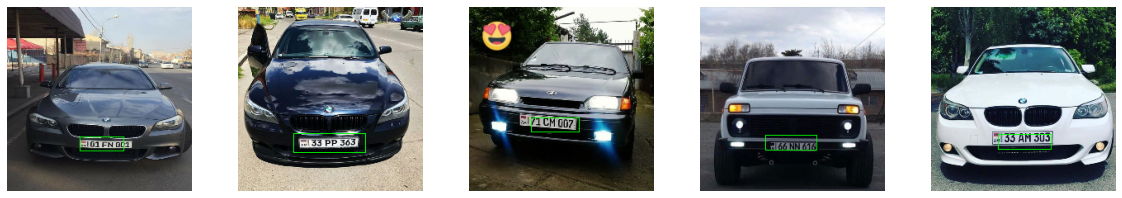

In [144]:
plt.figure(figsize=(20,40))
for i in range(0,5) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image=(X_unkown[i].copy()*255).astype(np.uint8)
    image = cv2.rectangle(image,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

# Analyze the problem

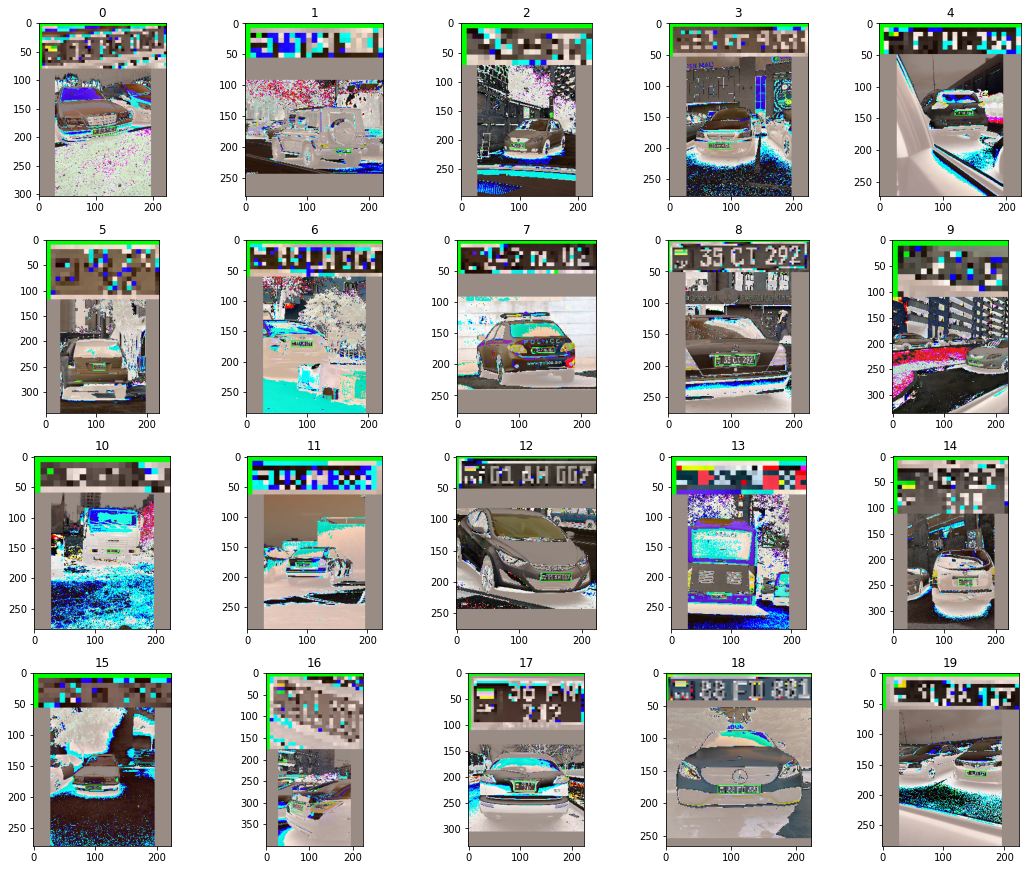

In [25]:
plt.figure(figsize=(15,30))
img_index=0
for i_car in range(0,20) :
    plt.subplot(10,5,img_index+1)
    ny=y_test[i_car]*255
    image=(X_test[i_car].copy()*255).astype(np.uint8)
    
    image=cv2.rectangle(image,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    
    yma,xma,ymi,xmi=int(ny[0]),int(ny[1]),int(ny[2]),int(ny[3])
    imup=image[xmi:xma,ymi:yma,:]
    coeff=int(image.shape[0]/(yma-ymi))
    imup=cv2.resize(image[xmi:xma,ymi:yma,:], (image.shape[0],(xma-xmi)*coeff), interpolation = cv2.INTER_AREA)
    vertical = np.concatenate((imup, image), axis = 0)
    plt.imshow(vertical)
    plt.title(f"{i_car}")
    img_index=img_index+1
plt.tight_layout()

## What about data quality and orientation?

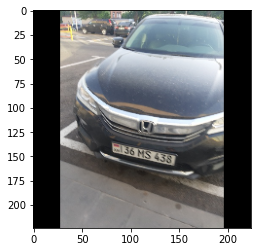

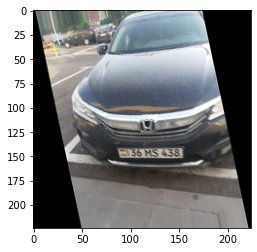

In [0]:
from scipy.ndimage import interpolation as inter
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
    
    return best_angle, rotated

for i_car in range(11,12):
    img=(X_test[i_car]*255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    best_angle,corr_im=correct_skew(img, delta=1, limit=25)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(cv2.cvtColor(corr_im, cv2.COLOR_BGR2RGB))
    plt.show()

# Data augmentation
* https://www.tensorflow.org/tutorials/images/data_augmentation